# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### A - Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### B- Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### C - Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

--------------------------------

**Elizabet Kenny** / DS-Online-25 Acámica / Diciembre 2020

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import itertools
import warnings
warnings.filterwarnings('ignore')

import nltk
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re 
from collections import Counter
from wordcloud import WordCloud 

**INFO DEL DATASET - Opción 2 NLP - AMAZON REVIEWS**
    
Proporcionamos un conjunto de datos de reseñas de productos de Amazon para la clasificación **entre el 1 de noviembre de 2015 y el 1 de noviembre de 2019.**

Para cada idioma, hay 200.000, 5.000 y 5.000 revisiones en los conjuntos de formación, desarrollo y prueba, respectivamente. La cantidad máxima de reseñas por revisor es 20 y la cantidad máxima de reseñas por producto es 20. Todas las reseñas se truncan después de 2000 caracteres y todas las reseñas tienen al menos 20 caracteres - Pues el Dataset esta dividido en 3 archivos, uno para entrenamiento, otro para testeo y el ultimo para validación.

Cada instacia cuenta con:
* ID de critica, 
* ID de producto, 
* ID de usuario, 
* cantidad de estrellas, 
* descripción, 
* título,
* lenguaje 
* categoría del producto.


El **OBJETIVO** en el cual me voy a centrar es en **implementa un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.**



In [2]:
data = pd.read_json('dataset_es_dev.json', lines=True)

In [3]:
data.shape

(5000, 8)

In [4]:
data_test = pd.read_json('dataset_es_test.json', lines=True)

In [5]:
data_test.shape

(5000, 8)

In [6]:
data_train = pd.read_json('dataset_es_train.json', lines=True)

In [7]:
data_train

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
...,...,...,...,...,...,...,...,...
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy


In [8]:
data_amazonfull= pd.concat([data, data_train, data_test], axis=0)
data_amazonfull #uniré todos para estudiarlos mejor

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty
...,...,...,...,...,...,...,...,...
4995,es_0685611,product_es_0919143,reviewer_es_0461769,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless
4996,es_0638242,product_es_0636134,reviewer_es_0214562,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless
4997,es_0760108,product_es_0078583,reviewer_es_0043609,5,Se ve bien el grabado,medallas con bonito grabado,es,home
4998,es_0070806,product_es_0359350,reviewer_es_0258717,5,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports


Inicialmente unifico los 3 dataset al notar que estaban divididos en trabajo previo, sin embargo los concateno para poder explorar con detenimiento en conjunto y luego decidir cómo trabajar con estos datos con 210.000 registros de reviews.

### A - Exploración de datos y Procesamiento del Lenguaje Natural

In [9]:
data_amazonfull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         210000 non-null  object
 1   product_id        210000 non-null  object
 2   reviewer_id       210000 non-null  object
 3   stars             210000 non-null  int64 
 4   review_body       210000 non-null  object
 5   review_title      210000 non-null  object
 6   language          210000 non-null  object
 7   product_category  210000 non-null  object
dtypes: int64(1), object(7)
memory usage: 14.4+ MB


In [10]:
data_amazonfull.describe() #unico feature numérico stars

,stars
count,210000.000000
mean,3.000000
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


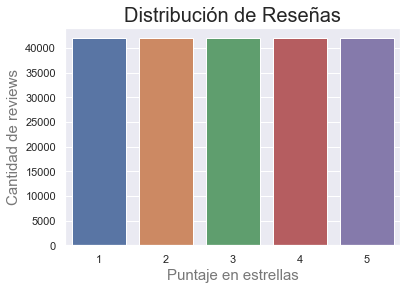

In [11]:
sns.countplot(x = 'stars', data = data_amazonfull)
plt.ylabel('Cantidad de reviews', size = 15, color ='#777777')
plt.xlabel('Puntaje en estrellas', size = 15, color ='#777777')
plt.title('Distribución de Reseñas', fontsize=20)
plt.show()

El dataset cuenta con una cantidad completamente distribuida de tipo de reviews en cada categoria de estrella.

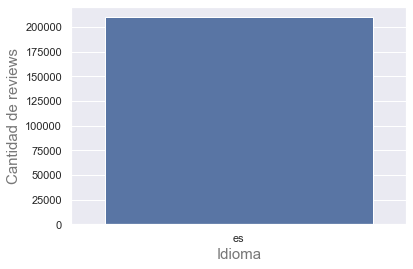

In [12]:
sns.countplot(x = 'language', data = data_amazonfull)
plt.ylabel('Cantidad de reviews', size = 15, color ='#777777')
plt.xlabel('Idioma', size = 15, color ='#777777')
plt.show()

Confirmo que todas las reviews sean en español

In [13]:
print('Cantidad de categorías:', len(data_amazonfull.product_category.unique()))

Cantidad de categorías: 30


¿De qué tipos de productos tenemos reviews?

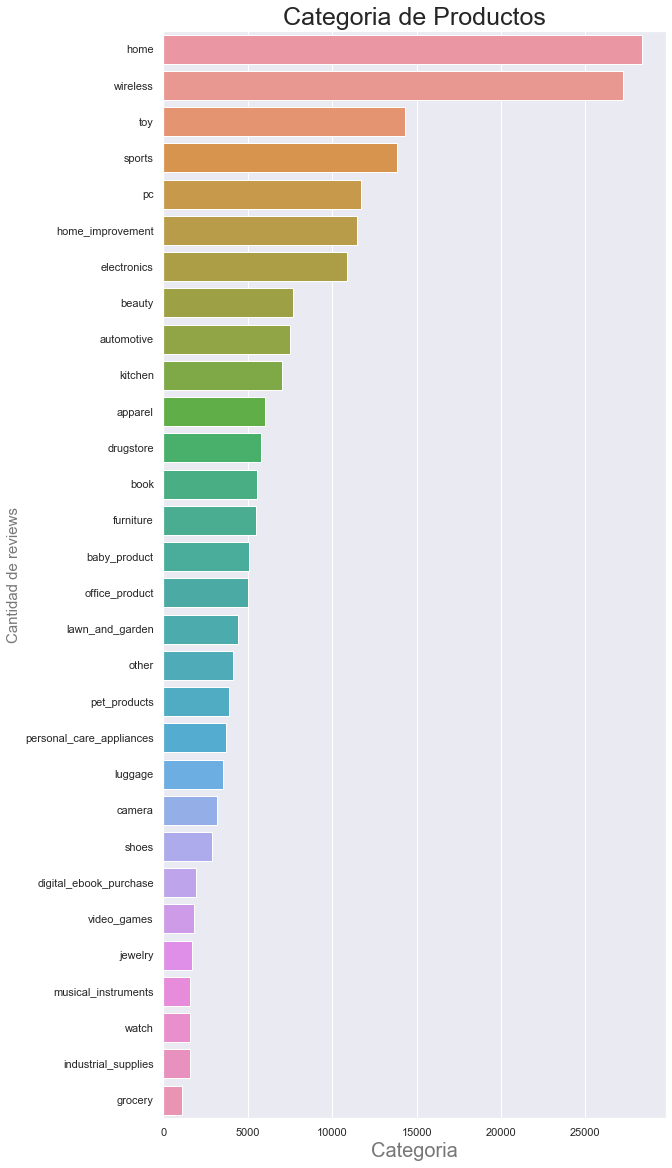

In [14]:
plt.figure(figsize = (9,20))

sns.countplot(y = 'product_category', 
              data = data_amazonfull,  
              order = data_amazonfull.product_category.value_counts().index)

#plt.xticks(rotation= 60)
plt.ylabel('Cantidad de reviews', size = 15, color ='#777777')
plt.xlabel('Categoria', size = 20, color ='#777777')
plt.title('Categoria de Productos', size=25)

plt.show()

¿Hay valores faltantes?

In [15]:
data_amazonfull.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

¿Cuantos usuarios unicos han hecho reseñas?

In [16]:
print('Cantidad de usuarios:', len(data_amazonfull.reviewer_id.unique()))

Cantidad de usuarios: 187140


¿Cuántas reviews hay por cada usuarios?

In [17]:
rev_us = data_amazonfull.reviewer_id.value_counts()
rev_us

reviewer_es_0588051    7
reviewer_es_0437514    7
reviewer_es_0431022    7
reviewer_es_0424425    6
reviewer_es_0691152    6
                      ..
reviewer_es_0601203    1
reviewer_es_0168533    1
reviewer_es_0667112    1
reviewer_es_0004229    1
reviewer_es_0845940    1
Name: reviewer_id, Length: 187140, dtype: int64

In [18]:
print('Experiencia de las 7 reviews del usuario 0437514: ')
data_train[data_train.reviewer_id == 'reviewer_es_0437514']

Experiencia de las 7 reviews del usuario 0437514: 


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
35801,es_0761893,product_es_0825301,reviewer_es_0437514,1,No estoy muy contenta. No se ven todas las apl...,No lo vilveria a comprar,es,pc
46687,es_0134144,product_es_0166287,reviewer_es_0437514,2,Yo lo compre como despertador para el dormitor...,Es muy grande,es,electronics
51789,es_0673033,product_es_0149056,reviewer_es_0437514,2,Debe influir quién te da el masaje o la fe.,No me sirve de nada,es,drugstore
82549,es_0564588,product_es_0315730,reviewer_es_0437514,3,"Las he comprado por su precio, algo mas barata...",No merece la pena,es,home
155874,es_0688433,product_es_0370804,reviewer_es_0437514,4,Eran las fechas navideñas y no lo encontrábamo...,Matilde,es,toy
176259,es_0167452,product_es_0117403,reviewer_es_0437514,5,Me las compre para fortalecer el suelo pélvico...,Funcionan,es,drugstore
194850,es_0765835,product_es_0202595,reviewer_es_0437514,5,Es perfecto para no encender las luces por la ...,Muy bien,es,home


¿Promedio de puntaje por categoria?

In [19]:
mean_p = data_amazonfull.groupby(['product_category'])[['stars']].mean().sort_values(by='stars', ascending=False)
mean_p

,stars
product_category,
book,3.404848
digital_ebook_purchase,3.361054
luggage,3.293531
musical_instruments,3.211443
grocery,3.159892
video_games,3.117712
camera,3.101572
shoes,3.100485
baby_product,3.088466


**Top 3 mejores y peores product_category promediales**

Distribución de las 3 mejores categorias AVG



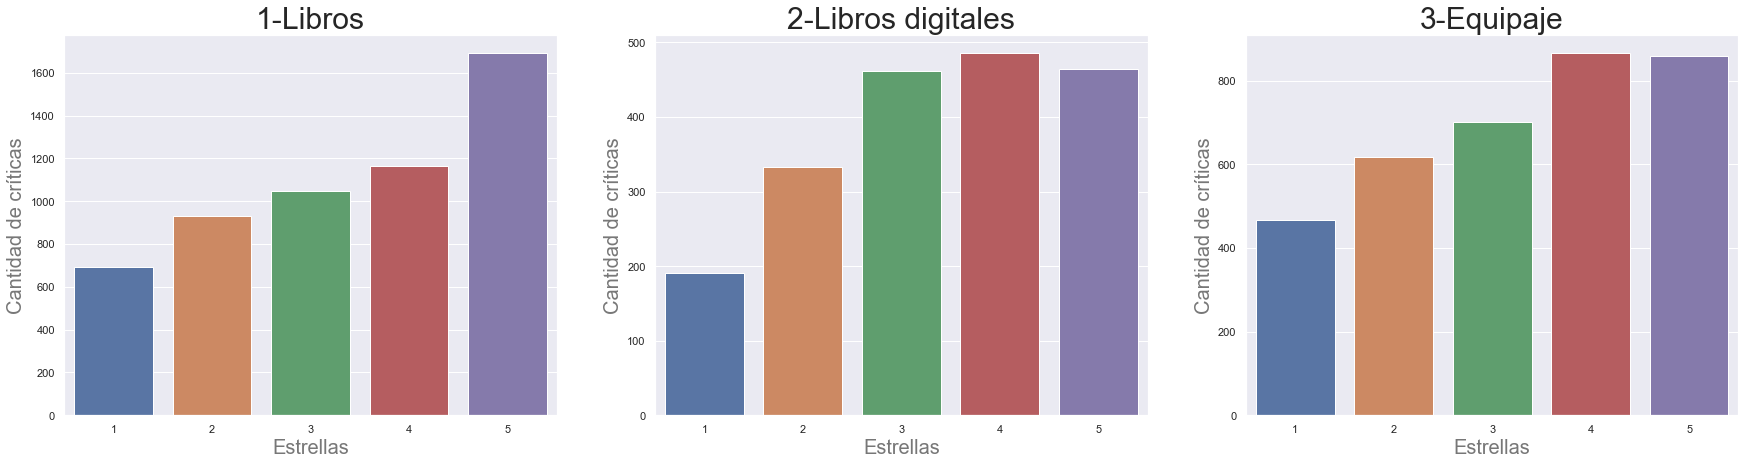

In [20]:
plt.figure(figsize=(30,7))

plt.subplot(131)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'book'])
plt.title('1-Libros', fontsize=30)
plt.xlabel('Estrellas', color ='#777777', fontsize=20)
plt.ylabel('Cantidad de críticas', color ='#777777', fontsize=20)

plt.subplot(132)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'digital_ebook_purchase'])
plt.title('2-Libros digitales', fontsize=30)
plt.xlabel('Estrellas', fontsize=20, color ='#777777')
plt.ylabel('Cantidad de críticas', fontsize=20, color ='#777777')

plt.subplot(133)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'luggage'])
plt.title('3-Equipaje', fontsize=30)
plt.xlabel('Estrellas', fontsize=20, color ='#777777')
plt.ylabel('Cantidad de críticas', fontsize=20, color ='#777777')


plt.show()

Distribución de las 3 peores categorias promediales 


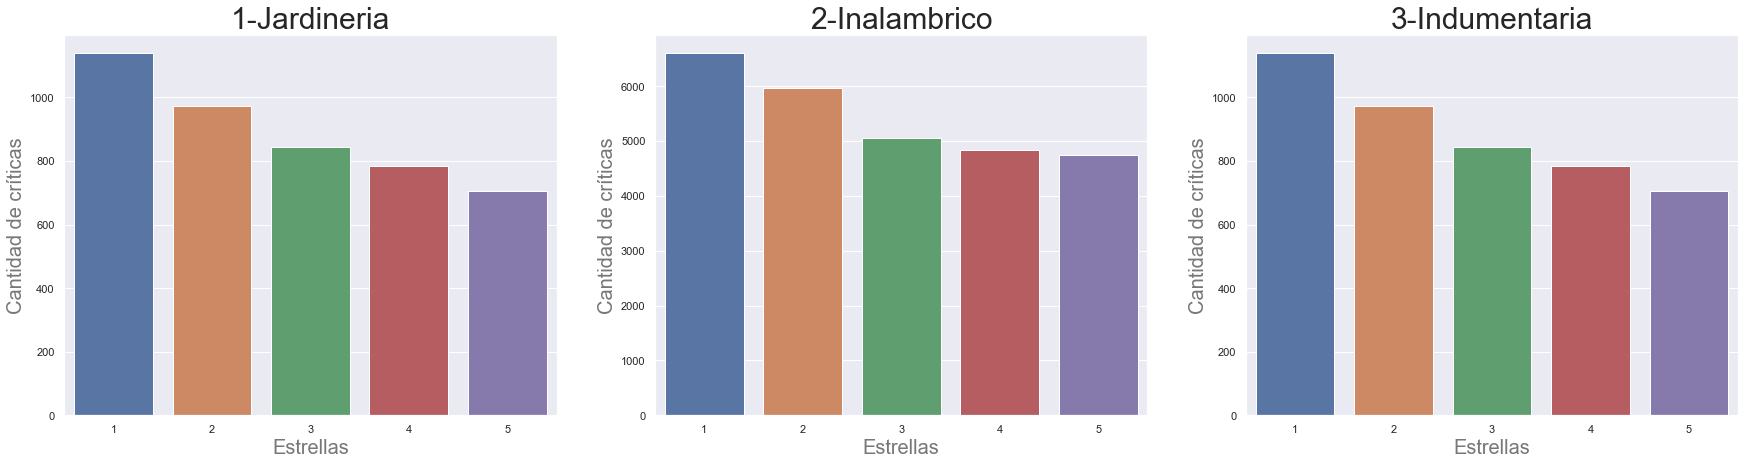

In [21]:
# Top 3 de peores puntuaciones por categoría de producto
plt.figure(figsize=(30,7))

plt.subplot(131)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'lawn_and_garden'])
plt.title('1-Jardineria', fontsize=30)
plt.xlabel('Estrellas', fontsize=20, color ='#777777')
plt.ylabel('Cantidad de críticas', fontsize=20, color ='#777777')

plt.subplot(132)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'wireless'])
plt.title('2-Inalambrico', fontsize=30)
plt.xlabel('Estrellas', fontsize=20, color ='#777777')
plt.ylabel('Cantidad de críticas', fontsize=20, color ='#777777')

plt.subplot(133)
sns.countplot(x = "stars", data = data_amazonfull[data_amazonfull['product_category']== 'lawn_and_garden'])
plt.title('3-Indumentaria', fontsize=30)
plt.xlabel('Estrellas', fontsize=20, color ='#777777')
plt.ylabel('Cantidad de críticas', fontsize=20, color ='#777777')

plt.show()

Ahora, con esta primera exploración, decido eliminar las columnas que creo que estan de más para continuar el analisis.

In [22]:
data_amazon = data_amazonfull.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id'])
data_amazon.head()

,stars,review_body,review_title,product_category
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty


Para comenzar analizar las palabras, unificaré el titulo con el body de las reviews.

In [23]:
data_amazon['review_full'] = data_amazon['review_title'] + ' ' + data_amazon['review_body']
data_amazon.head()

,stars,review_body,review_title,product_category,review_full
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,No lo he recibido No he recibido el pedido no ...
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,Que no aprieta bien en el manillar Tengo que b...
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,No me gusta No me gusta su olor a viejo y aspe...


### Lemmatización o stemming

In [24]:
import es_core_news_sm
nlp = es_core_news_sm.load() 

In [25]:
#data_amazon['review_lemm'] = '' #inicia con string vacio
#stop_words = nlp.Defaults.stop_words

#for i in range(data_amazon.shape[0]):
#    review = data_amazon.iloc[i].review_full #seleccionar la review
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_amazon['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data_amazon.to_csv('DS_Proyecto_03_data_amazon_lemma.csv', index = False, encoding = 'utf-8') #lo guardo a parte

In [26]:
df_amazon = pd.read_csv('DS_Proyecto_03_data_amazon_lemma.csv')
df_amazon

,stars,review_body,review_title,product_category,review_full,review_lemm
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,"Mala compra Malisimo, muy grande demasiado apa...",malo comprar malisimo grande aparatoso y prote...
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,No lo he recibido No he recibido el pedido no ...,recibir recibir pedir devolución
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,Que no aprieta bien en el manillar Tengo que b...,apretar manillar buscar sistema funcionar abra...
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,broca mantequilla utilizar broca menor diámetr...
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,No me gusta No me gusta su olor a viejo y aspe...,gustar gustar olor a viejo y aspecto malo
...,...,...,...,...,...,...
209995,5,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,wireless,Perfectos para lo que sirven Para lo que cuest...,perfecto servir costar perfecto cumplir funció...
209996,5,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",wireless,"Buen vendedor, rápido y fiable. Material muy f...",vendedor rápido y fiable material flexible y c...
209997,5,Se ve bien el grabado,medallas con bonito grabado,home,medallas con bonito grabado Se ve bien el grabado,medalla bonito grabar ver grabar
209998,5,lo compré para mi bici pero finalmente se lo h...,timbre,sports,timbre lo compré para mi bici pero finalmente ...,timbrar comprar bici finalmente quedar xiaomi ...


In [27]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   stars             210000 non-null  int64 
 1   review_body       210000 non-null  object
 2   review_title      210000 non-null  object
 3   product_category  210000 non-null  object
 4   review_full       210000 non-null  object
 5   review_lemm       209954 non-null  object
dtypes: int64(1), object(5)
memory usage: 9.6+ MB


In [28]:
df_amazon['review_lemm'] = df_amazon['review_lemm'].apply(str)

In [29]:
df_amazon.shape

(210000, 6)

In [30]:
210000/5

42000.0

Dividiré el dataset por sus estrellas clasificadas para ver qué palabras contienen sobre todo.

In [31]:
df_1s = df_amazon[df_amazon.stars == 1]
df_2s = df_amazon[df_amazon.stars == 2]
df_3s = df_amazon[df_amazon.stars == 3]
df_4s = df_amazon[df_amazon.stars == 4]
df_5s = df_amazon[df_amazon.stars == 5]

In [32]:
df_1s.shape

(42000, 6)

In [33]:
r_1s = []
for i in range(df_1s.shape[0]):
    titular = df_1s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_1s.append(titular) #agregar el resultado a la lista

r_1s

[['malo',
  'comprar',
  'malisimo',
  'grande',
  'aparatoso',
  'protector',
  'pantalla'],
 ['recibir', 'recibir', 'pedir', 'devolución'],
 ['apretar',
  'manillar',
  'buscar',
  'sistema',
  'funcionar',
  'abrazadera',
  'agarrar',
  'manillar',
  'apretar',
  'deslizar',
  'linterna',
  'abajar'],
 ['broca',
  'mantequilla',
  'utilizar',
  'broca',
  'menor',
  'diámetro',
  'doblar',
  'ser',
  'mantequilla',
  'mínimo',
  'presión',
  'doblar',
  'enderezarlas',
  'partir',
  'exteriormente',
  'amarillo',
  'interior',
  'fundir',
  'gris',
  'comprar'],
 ['gustar', 'gustar', 'olor', 'viejo', 'aspecto', 'malo'],
 ['bola', 'rotar', 'hola', 'recoger', 'paquete', 'llegar', 'bola', 'rotar'],
 ['elegir',
  'color',
  'elegir',
  'color',
  'envian',
  'cesto',
  'color',
  'asar',
  'imaginar',
  'aprovechar',
  'romper',
  'color',
  'aleatorio',
  'foto',
  'cesta',
  'asar',
  'color',
  'recomer',
  'comprarlo',
  'elegir',
  'color',
  'único',
  'aliviar',
  'romper',
  'ca

In [34]:
r_1s = list(itertools.chain(*r_1s))

word_freq = Counter(r_1s)
common_words_1s = word_freq.most_common()

print('Lista de palabras más comunes para críticas de 1 estrella')
df_r_1s = pd.DataFrame(common_words_1s, columns = ['Words', 'Frequency'])
df_r_1s.head(15)

Lista de palabras más comunes para críticas de 1 estrella


,Words,Frequency
0,producto,10042
1,llegar,9823
2,comprar,9700
3,malo,8851
4,funcionar,7978
5,calidad,7094
6,devolver,4758
7,pedir,4711
8,venir,4268
9,recibir,4158


In [35]:
r_2s = []
for i in range(df_2s.shape[0]):
    titular = df_2s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_2s.append(titular) #agregar el resultado a la lista
    
r_2s = list(itertools.chain(*r_2s))

word_freq = Counter(r_2s)
common_words_2s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 2 estrellas')
df_r_2s = pd.DataFrame(common_words_2s, columns = ['Words', 'Frequency'])
df_r_2s.head(15)

Lista de palabras más comunes para críticas de 2 estrellas


,Words,Frequency
0,calidad,9324
1,comprar,7415
2,producto,6158
3,funcionar,5897
4,malo,5314
5,pequeño,4597
6,venir,4543
7,esperar,4282
8,llegar,4188
9,preciar,4186


In [36]:
r_3s = []
for i in range(df_3s.shape[0]):
    titular = df_3s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_3s.append(titular) #agregar el resultado a la lista
    
r_3s = list(itertools.chain(*r_3s))

word_freq = Counter(r_3s)
common_words_3s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 3 estrellas')
df_r_3s = pd.DataFrame(common_words_3s, columns = ['Words', 'Frequency'])
df_r_3s.head(15)

Lista de palabras más comunes para críticas de 3 estrellas


,Words,Frequency
0,calidad,8976
1,preciar,7663
2,producto,5495
3,pequeño,4968
4,comprar,4907
5,esperar,4487
6,funcionar,4274
7,gustar,4106
8,venir,3964
9,bonito,3648


In [37]:
r_4s = []
for i in range(df_4s.shape[0]):
    titular = df_4s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_4s.append(titular) #agregar el resultado a la lista
    
r_4s = list(itertools.chain(*r_4s))

word_freq = Counter(r_4s)
common_words_4s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 4 estrellas')
df_r_4s = pd.DataFrame(common_words_4s, columns = ['Words', 'Frequency'])
df_r_4s.head(15)

Lista de palabras más comunes para críticas de 4 estrellas


,Words,Frequency
0,calidad,11928
1,preciar,11013
2,producto,6728
3,comprar,6463
4,perfecto,5458
5,cumplir,5043
6,gustar,4433
7,funcionar,4195
8,bonito,3952
9,esperar,3595


In [38]:
r_5s = []
for i in range(df_5s.shape[0]):
    titular = df_5s.iloc[i].review_lemm #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_5s.append(titular) #agregar el resultado a la lista
    
r_5s = list(itertools.chain(*r_5s))

word_freq = Counter(r_5s)
common_words_5s = word_freq.most_common()
print('Lista de palabras más comunes para críticas de 5 estrellas')
df_r_5s = pd.DataFrame(common_words_5s, columns = ['Words', 'Frequency'])
df_r_5s.head(15)

Lista de palabras más comunes para críticas de 5 estrellas


,Words,Frequency
0,calidad,12779
1,perfecto,11495
2,comprar,9202
3,preciar,8632
4,producto,6920
5,encantar,5199
6,genial,4088
7,bonito,3980
8,funcionar,3821
9,gustar,3636


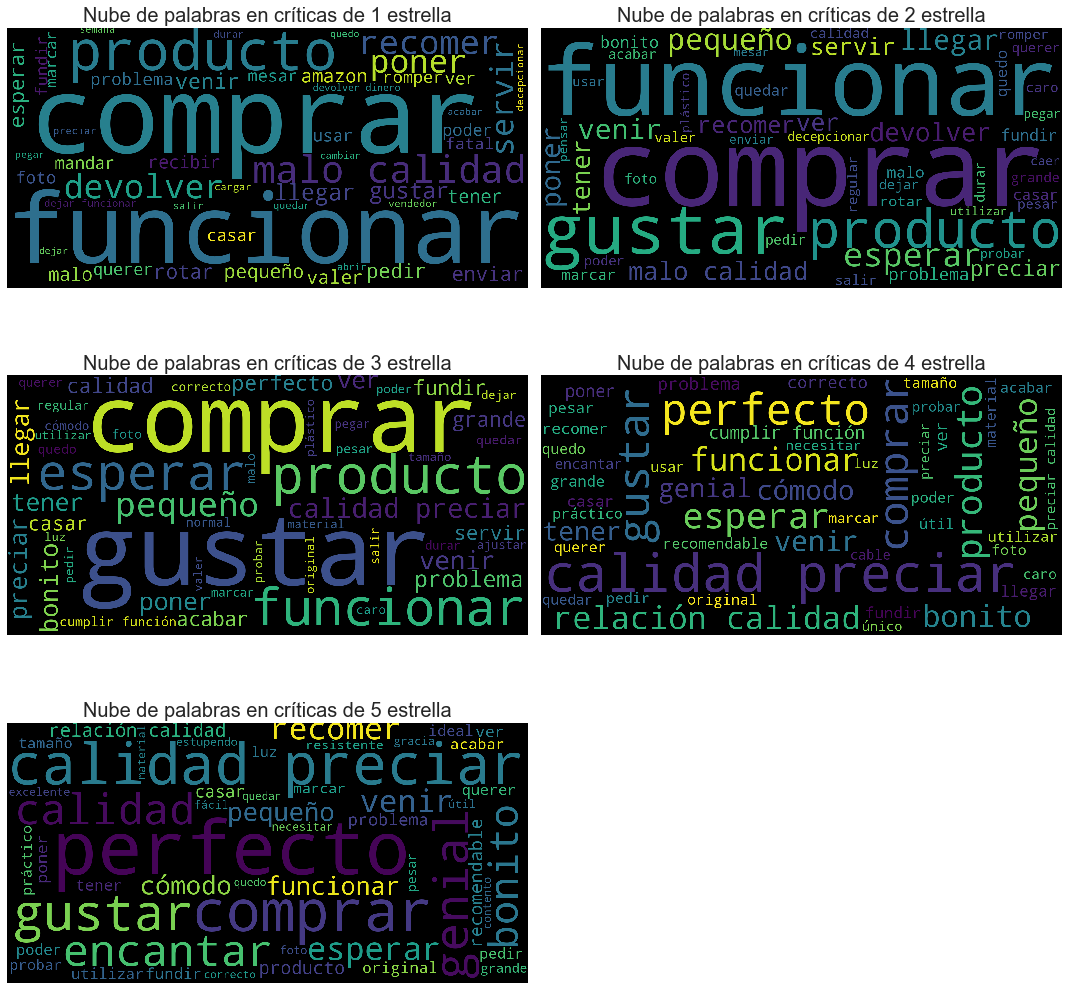

In [39]:
plt.figure(figsize=(15,15))

plt.subplot(321)
u_string=(" ").join(r_1s)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 1 estrella', fontsize=20)

plt.subplot(322)
u_string2=(" ").join(r_2s)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string2)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 2 estrella', fontsize=20)

plt.subplot(323)
u_string3=(" ").join(r_3s)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string3)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 3 estrella', fontsize=20)

plt.subplot(324)
u_string4=(" ").join(r_4s)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string4)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 4 estrella', fontsize=20)

plt.subplot(325)
u_string5=(" ").join(r_5s)
wc = WordCloud(max_words = 50, width = 1600 , height = 800 ).generate(u_string5)
plt.imshow(wc)
plt.axis("off")
plt.title('Nube de palabras en críticas de 5 estrella', fontsize=20)

plt.tight_layout()
plt.show()

Con el recurso de nube de palabras se puede observar mejor la similitud entre opiniones negativas (1, 2 y 3 estrellas) y positivas (4 y 5 estrellas). El tamaño de cada palabra indica su frecuencia o importancia en las críticas. 

Voy a graficar para poder ver mejor las frecuecias por palabra.

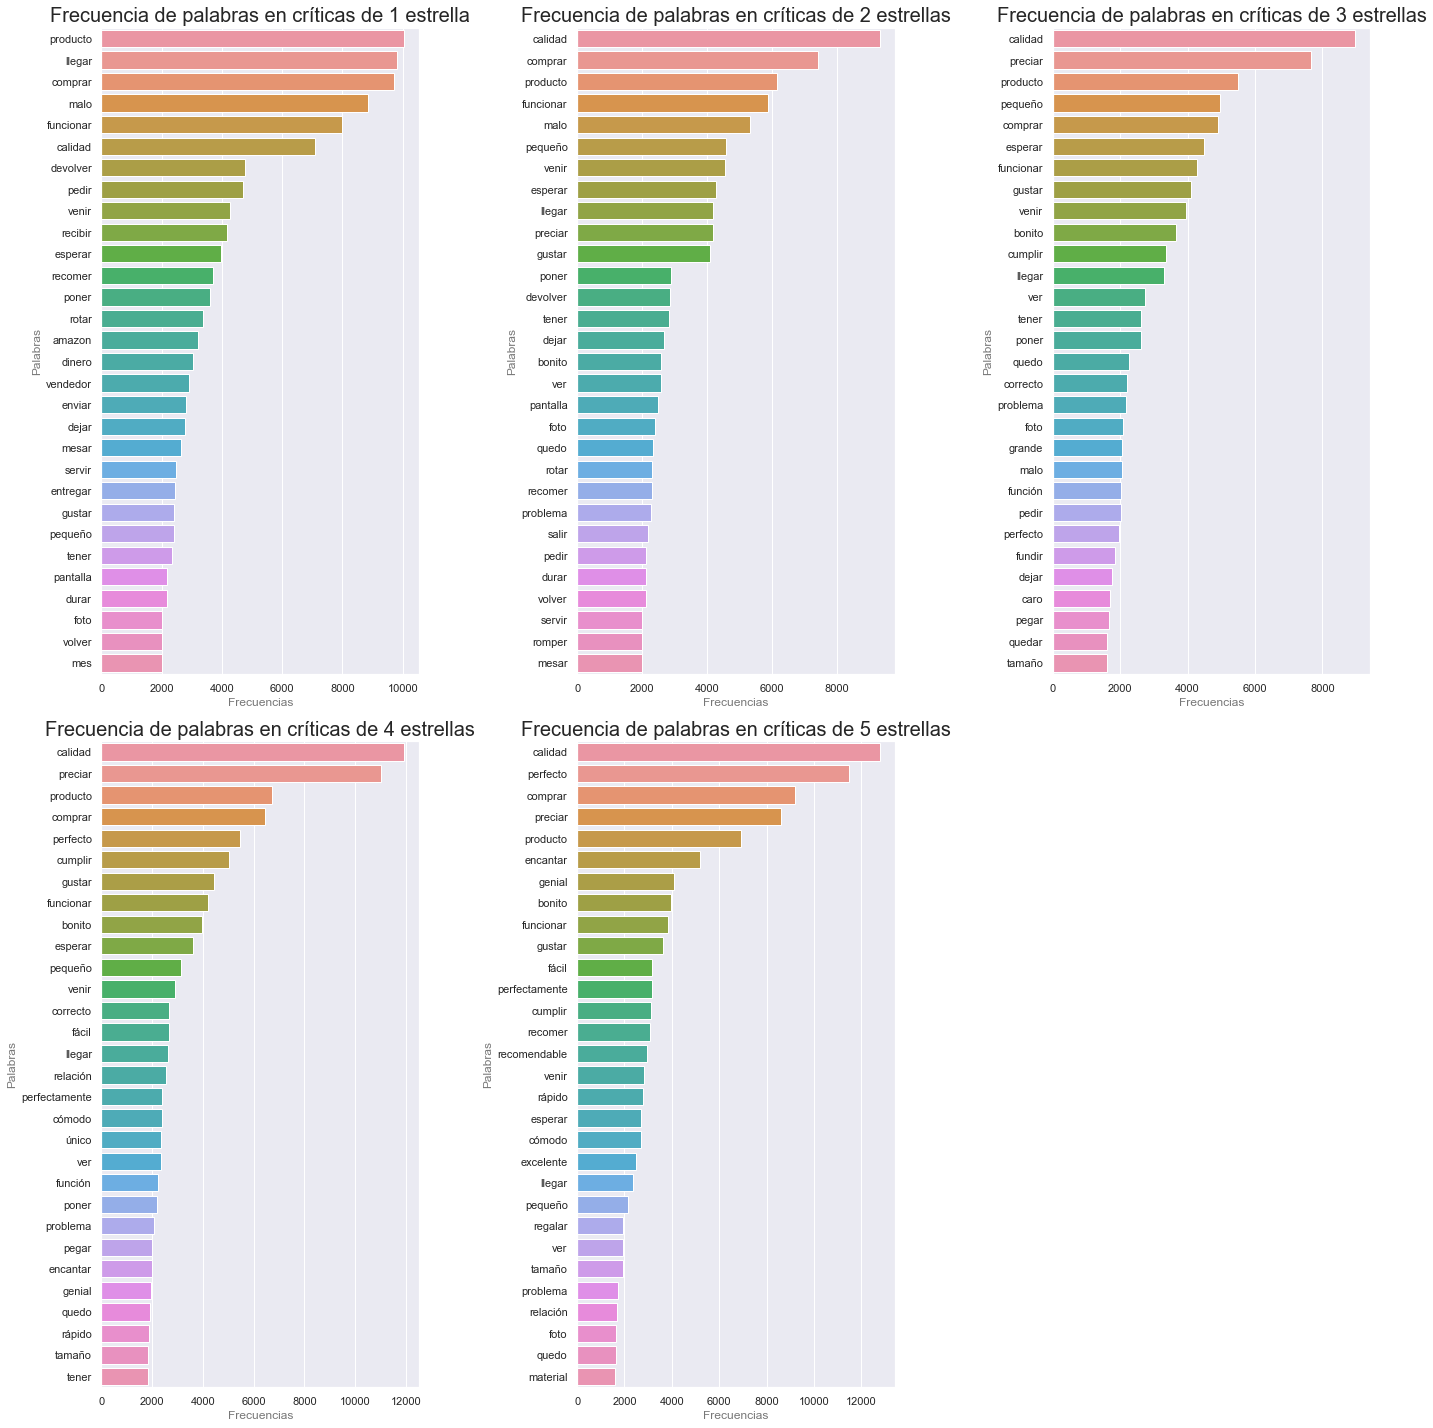

In [40]:
plt.figure(figsize = (20,20))

plt.subplot(231)
plot = sns.barplot(y = df_r_1s.iloc[:30].Words, x = df_r_1s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 1 estrella', fontsize=20)
plt.xlabel('Frecuencias', color ='#777777')
plt.ylabel('Palabras', color ='#777777')

plt.subplot(232)
plot = sns.barplot(y  = df_r_2s.iloc[:30].Words, x = df_r_2s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 2 estrellas', fontsize=20)
plt.xlabel('Frecuencias', color ='#777777')
plt.ylabel('Palabras', color ='#777777')

plt.subplot(233)
plot = sns.barplot(y  = df_r_3s.iloc[:30].Words, x = df_r_3s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 3 estrellas', fontsize=20)
plt.xlabel('Frecuencias', color ='#777777')
plt.ylabel('Palabras', color ='#777777')

plt.subplot(234)
plot = sns.barplot(y  = df_r_4s.iloc[:30].Words, x = df_r_4s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 4 estrellas', fontsize=20)
plt.xlabel('Frecuencias', color ='#777777')
plt.ylabel('Palabras', color ='#777777')

plt.subplot(235)
plot = sns.barplot(y  = df_r_5s.iloc[:30].Words, x = df_r_5s.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas de 5 estrellas', fontsize=20)
plt.xlabel('Frecuencias', color ='#777777')
plt.ylabel('Palabras', color ='#777777')

plt.tight_layout()
plt.show()

Voy a comprobar una idea que tengo: ¿las criticas negativas tienen más palabras que las positivas?

Creo una columna con la cuenta de caracteres por crítica:

In [41]:
df_amazon['count_word'] = df_amazon["review_full"].apply(lambda x: len(str(x).split()))
df_amazon.head()

,stars,review_body,review_title,product_category,review_full,review_lemm,count_word
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,wireless,"Mala compra Malisimo, muy grande demasiado apa...",malo comprar malisimo grande aparatoso y prote...,12
1,1,No he recibido el pedido no la devolución,No lo he recibido,apparel,No lo he recibido No he recibido el pedido no ...,recibir recibir pedir devolución,12
2,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,sports,Que no aprieta bien en el manillar Tengo que b...,apretar manillar buscar sistema funcionar abra...,35
3,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,broca mantequilla utilizar broca menor diámetr...,55
4,1,No me gusta su olor a viejo y aspecto malo,No me gusta,beauty,No me gusta No me gusta su olor a viejo y aspe...,gustar gustar olor a viejo y aspecto malo,13


¿Cual es el número de palabras promedio por estrellas?

In [42]:
avg_w = df_amazon.groupby(['stars'])[['count_word']].mean()
avg_w = avg_w.dropna(axis=0)
print(avg_w)

       count_word
stars            
1       32.023286
2       34.969405
3       32.242119
4       28.965952
5       27.383048


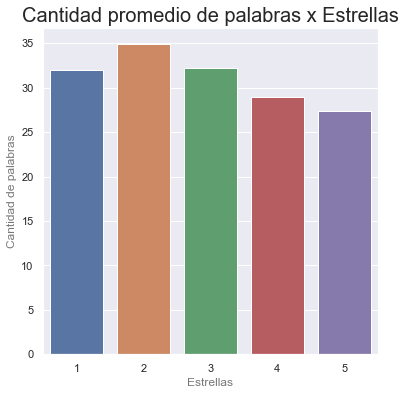

In [43]:
plt.figure(figsize=(6,6)) #Grafico
sns.barplot(data = df_amazon, x = "stars", y = "count_word", ci = None )
plt.title('Cantidad promedio de palabras x Estrellas', fontsize= 20)
plt.xlabel('Estrellas', color ='#777777')
plt.ylabel('Cantidad de palabras', color ='#777777')
plt.show()

Si, hay una tendencia a escribir más ante las malas experiencias.

### B- Machine Learning

Para comenzar a trabajar ML usaré la división prolija de los dataset bajadas originalmente: data_train, data_test y data para validar.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [45]:
data_test['review_full'] = data_test['review_title'] + ' ' + data_test['review_body']
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_full
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless,no me llego no me llego el articulo me lo mand...
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home,amazon sigue sin cumplir en las entregas la me...
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home,Estafa de Amazon Mi valoración no es sobre el ...
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...


In [46]:
data_train['review_full'] = data_train['review_title'] + ' ' + data_train['review_body']
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_full
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,television Nevir Nada bueno se me fue ka panta...
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,Dinero tirado a la basura con esta compra Horr...
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,solo llega una unidad cuando te obligan a comp...
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes,Devuelto Llega tarde y co la talla equivocada


In [47]:
data['review_full'] = data['review_title'] + ' ' + data['review_body']
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_full
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,No lo he recibido No he recibido el pedido no ...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,Que no aprieta bien en el manillar Tengo que b...
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,No me gusta No me gusta su olor a viejo y aspe...


Para avanzar en ML unifico la review en 1 columna(`review_full`) y eliminaré el resto de columnas de review. Y el resto de columnas que no me servirán en este caso.

In [48]:
data_test = data_test.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])
data_train = data_train.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])
data= data.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

In [49]:
data_test

,stars,product_category,review_full
0,1,wireless,no me llego no me llego el articulo me lo mand...
1,1,home,amazon sigue sin cumplir en las entregas la me...
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...
...,...,...,...
4995,5,wireless,Perfectos para lo que sirven Para lo que cuest...
4996,5,wireless,"Buen vendedor, rápido y fiable. Material muy f..."
4997,5,home,medallas con bonito grabado Se ve bien el grabado
4998,5,sports,timbre lo compré para mi bici pero finalmente ...


In [50]:
data_train

,stars,product_category,review_full
0,1,electronics,television Nevir Nada bueno se me fue ka panta...
1,1,electronics,Dinero tirado a la basura con esta compra Horr...
2,1,drugstore,solo llega una unidad cuando te obligan a comp...
3,1,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,1,shoes,Devuelto Llega tarde y co la talla equivocada
...,...,...,...
199995,5,electronics,Tal y como se describe Mando funciona perfecta...
199996,5,electronics,Funciona perfectamente Compré la batería con c...
199997,5,apparel,Buena calidad. Buena calidad. Satisfecha con l...
199998,5,toy,Recomendado Perfecto para el cumple de mi hijo


In [51]:
data

,stars,product_category,review_full
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa..."
1,1,apparel,No lo he recibido No he recibido el pedido no ...
2,1,sports,Que no aprieta bien en el manillar Tengo que b...
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...
...,...,...,...
4995,5,home,guadalupe Me ha encantado la cesta. Ha llegado...
4996,5,camera,calidad precio Desempeña su función correctamente
4997,5,toy,Excelente Me ha encantado la diadema! Las flor...
4998,5,wireless,"Genial A mi me gustan mucho las fundas TPU, ya..."


Continuo con lemización.

In [52]:
#data_test['review_lemm'] = ''
#stop_words = nlp.Defaults.stop_words

#for i in range(data_test.shape[0]):
#    review = data_test.iloc[i].review_full
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_test['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data_test.to_csv('DS_Proyecto_03_data_test_lemma.csv', index = False, encoding = 'utf-8')

In [53]:
data_test = pd.read_csv('DS_Proyecto_03_data_test_lemma.csv')
data_test['review_lemm'] = data_test['review_lemm'].apply(str)
data_test.head()

,stars,product_category,review_full,review_lemm
0,1,wireless,no me llego no me llego el articulo me lo mand...,llegar llegar articular mandar correo normal s...
1,1,home,amazon sigue sin cumplir en las entregas la me...,amazon cumplir entregar mensajería horrible co...
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,estafar enviar decepcionar vendedor pedir a y ...
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...,estafar amazon valoración producto amazon ofre...
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...,conseguir pasar portar kindle interés librar y...


In [54]:
#data_train['review_lemm'] = ''
#stop_words = nlp.Defaults.stop_words

#for i in range(data_train.shape[0]):
#    review = data_train.iloc[i].review_full
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data_train['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data_train.to_csv('DS_Proyecto_03_data_train_lemma.csv', index = False, encoding = 'utf-8')

In [55]:
data_train = pd.read_csv('DS_Proyecto_03_data_train_lemma.csv')
data_train['review_lemm'] = data_train['review_lemm'].apply(str)
data_train.head()

,stars,product_category,review_full,review_lemm
0,1,electronics,television Nevir Nada bueno se me fue ka panta...,television nevir ka pantalla 8 mesar y recibir...
1,1,electronics,Dinero tirado a la basura con esta compra Horr...,dinero tirar a basura comprar horrible tener c...
2,1,drugstore,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar a comprar obligar a comp...
3,1,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto recibir entrar descalificar vendedor ...
4,1,shoes,Devuelto Llega tarde y co la talla equivocada,devolver llegar y co tallar equivocar


In [56]:
#data['review_lemm'] = ''
#stop_words = nlp.Defaults.stop_words

#for i in range(data.shape[0]):
#    review = data.iloc[i].review_full
#    review_tk = nltk.RegexpTokenizer('\w+').tokenize(review)
#    review_tk_lower_stop = [word.lower() for word in review_tk if word.lower() not in stop_words]
#    review_clean = ' '.join(review_tk_lower_stop)
#    review_clean = nlp(review_clean)
#    lemmas_list = [word.lemma_ for word in review_clean]
#    data['review_lemm'].iloc[i] = ' '.join(lemmas_list)
    
#data.to_csv('DS_Proyecto_03_data_dev.csv', index = False, encoding = 'utf-8')

In [57]:
data = pd.read_csv('DS_Proyecto_03_data_dev.csv')
data['review_lemm'] = data['review_lemm'].apply(str)
data.head()

,stars,product_category,review_full,review_lemm
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa...",malo comprar malisimo grande aparatoso y prote...
1,1,apparel,No lo he recibido No he recibido el pedido no ...,recibir recibir pedir devolución
2,1,sports,Que no aprieta bien en el manillar Tengo que b...,apretar manillar buscar sistema funcionar abra...
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,broca mantequilla utilizar broca menor diámetr...
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...,gustar gustar olor a viejo y aspecto malo


Hasta ahora entonces, tenemos un grupo de palabras por cada review (**bag of words**) lematizadas.

**TF-IDF**

TF-IDF significa "Term Frequency-Inverse Document Frequency". Term Frequency significa: cuántas veces un término aparece en un documento. La importancia de esto es que se supone que mientras más veces aparece, más importante es ese término en ese documento, y Inverse Document Frequency significa que se compara la frecuencia de la palabra en ese documento con la frecuencia en todo el corpus de documentos. A mayor frecuencia de la palabra en todos los documentos, menor puntaje tendrá. 

El valor de TF-IDF aumenta al numero de veces que una palabra aparece en el documento, proporcionalmente.

Ahora pasamos a buscar representar las palabras como un vector. Para poder aplicar todo esto, utilizaré la herramienta de Scikit-Learn, `TfidfVectorizer`. Esta se encarga de calcula los recuentos de palabras, los valores idf y tf-idf todos a la vez, conviertiendo una colección de documentos crudos a una matriz de caracteres TF-IDF.

In [58]:
list_review_test = list(data_test['review_lemm'].values) #test
calif_test = data_test['stars'].values

list_review_train = list(data_train['review_lemm'].values) #train
calif_train = data_train['stars'].values 

list_review_dev = list(data['review_lemm'].values) #data dev
calif_dev = data['stars'].values 

#TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, min_df=30)

#Transformo en matriz
matriz_review_test= tfidf.fit_transform(list_review_test)
matriz_review_train = tfidf.transform(list_review_train)
matriz_review_dev = tfidf.transform(list_review_dev)

print('Train', matriz_review_train.shape)
print('Test', matriz_review_test.shape)
print('Data dev ', matriz_review_dev.shape)

Train (200000, 340)
Test (5000, 340)
Data dev  (5000, 340)


Cambio los tipos de datos de las matrices para mayor agilidad.


In [59]:
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_test = matriz_review_test.astype('float32')
calif_test= calif_test.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev= calif_dev.astype('int8')

### Modelado ML

*Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.*

Trabajaremos con modelos de **clasificación** ya que el resultado es a buscar aquí es una clase, entre un número limitado de clases. Con clases me refiero a categorías arbitrarias según el tipo de problema, en este caso asignar a ana categoria de crítica (stars).

Defino X e y

In [60]:
#TRAIN
X_train = matriz_review_train.toarray()
y_train = calif_train

#TEST
X_test = matriz_review_test.toarray()
y_test = calif_test

#DATA
X_dev = matriz_review_dev.toarray()
y_dev = calif_dev

**Benchmark**

Tomare Gaussian Naive Bayes como punto de partida de referencia para el accuracy.

En este sentido, los modelos de Naive Bayes son una clase especial de algoritmos de clasificación de Machine Learning. Se basan en una técnica de clasificación estadística llamada “teorema de Bayes” y son algoritmos llamados "Naive" o "Inocentes", en español. En ellos se asume que las variables predictoras son independientes entre sí. En otras palabras, que la presencia de una cierta característica en un conjunto de datos no está en absoluto relacionada con la presencia de cualquier otra característica.
Proporcionan una manera fácil de construir modelos con un comportamiento muy bueno debido a su simplicidad.
Lo consiguen proporcionando una forma de calcular la probabilidad ‘posterior’ de que ocurra un cierto evento A, dadas algunas probabilidades de eventos ‘anteriores’.


*(Extraido de medium.com - https://medium.com/datos-y-ciencia/algoritmos-naive-bayes-fudamentos-e-implementaci%C3%B3n-4bcb24b307f)*

In [61]:
nb = GaussianNB()
nb.fit(X_train,y_train)
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))

Accuracy train NB:  0.414865
Accuracy test NB:  0.4212


Matriz de Confusión

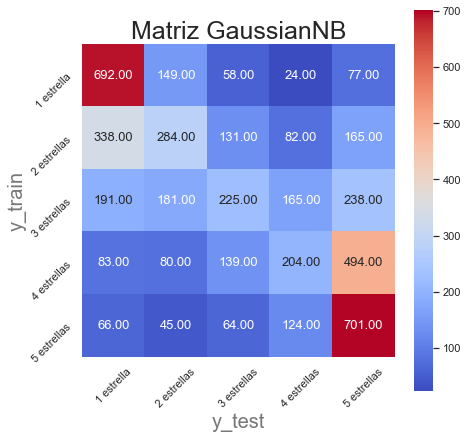

In [62]:
names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm = confusion_matrix(y_test,y_test_pred)
f,ax = plt.subplots(figsize=(7,7))
sns.heatmap(cm, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm',ax=ax)

plt.xlabel("y_test", size =20, color ='#777777')
plt.ylabel("y_train", size =20, color ='#777777')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Matriz GaussianNB", size = 25)
plt.show()

Ahora comenzaré a probar con algunos Modelos de ML

In [63]:
random_forest = RandomForestClassifier(max_depth=20, 
                                       random_state=42)

In [64]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [65]:
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

print("Accuracy train RF: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test RF: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy train RF:  0.48551
Accuracy test RF:  0.4256


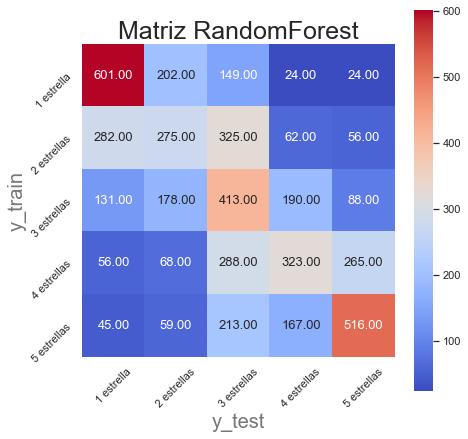

In [66]:
names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm=confusion_matrix(y_test,y_test_pred_rf)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm',ax=ax)
plt.xlabel("y_test", size =20, color ='#777777')
plt.ylabel("y_train", size =20, color ='#777777')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Matriz RandomForest", size = 25)
plt.show()

Este modelo performa mejor las estrellas 3 que el modelo anterior sin embargo poe la diferencia entre train y test puedo notar un sobre ajuste del modelo.

**Linear SVC**

In [67]:
svc = LinearSVC(C = 1, random_state=42)
svc.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [68]:
y_train_pred_svc= svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))

Accuracy train SVC:  0.46209
Accuracy test SVC:  0.4652


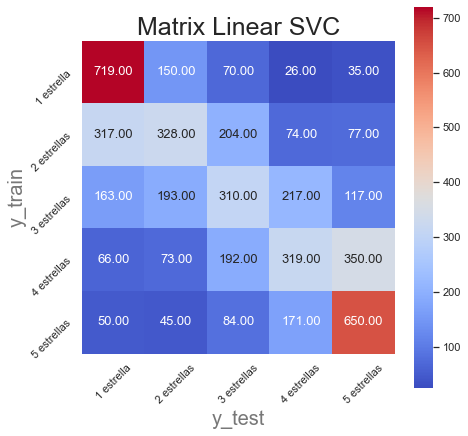

In [69]:
names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm=confusion_matrix(y_test,y_test_pred_svc)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm',ax=ax)
plt.xlabel("y_test", size =20, color ='#777777')
plt.ylabel("y_train", size =20, color ='#777777')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Matrix Linear SVC", size = 25)
plt.show()

Puedo destacar los mejores resultados en los modelos entrenados que en Benchmark, pero se puede notar un overgitting en ambos casos.


Usé como metrica el Accuracy, la precisión es el porcentaje total de los elementos clasificados correctamente. El dataset esta perfectamente balanceado por lo que considero que es una buena medida para utilizar.

In [70]:
print('--Result--')
print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test RF: ", accuracy_score(y_test, y_test_pred_rf))
print('--------------------------')
print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))

--Result--
Accuracy train NB:  0.414865
Accuracy test NB:  0.4212
--------------------------
Accuracy train RF:  0.48551
Accuracy test RF:  0.4256
--------------------------
Accuracy train SVC:  0.46209
Accuracy test SVC:  0.4652


A modo de comparativa vemos que el modelo que mejor rinde es el de Randon Forest en train 48% pero test 42%, podria ser que esta realizando un overfitting, en este sentido entonces SVC rinde mejor en train y test a un 46%, siendo el que creo que mejor performance realiza aqui.

Luego viendo en detalle cada matriz de confusión se determina que el modelo, en este caso SVC, clasifica bien las criticas de 1 y 5 estrellas pero tiene dificultades para clasificar las reviews intermedias.

**Optmización de Modelos**

Primeor para optmizar creo que podría ser bueno mejorar el `TfidfVectorizer`. Anteriormente se estaba vectorizando palabra por palabra, ahora al variar el hiperparámetro "ngram_range" estoy teienendo en cuenta las 1000 palabras más frecuentes, pero estas son una sola palabra y una frase compuesta por 2 palabras. De esta manera le da mayor peso al contexto.

Usando los pasos anteriores nuevamente:

In [71]:
list_review_test = list(data_test['review_lemm'].values) #test
calif_test = data_test['stars'].values

list_review_train = list(data_train['review_lemm'].values) #train
calif_train = data_train['stars'].values 
 

#TfidfVectorizer optmizado
vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))

#Transformo en matriz
matriz_review_test= vectorizer.fit_transform(list_review_test)
matriz_review_train = vectorizer.transform(list_review_train)

print('Train', matriz_review_train.shape)
print('Test', matriz_review_test.shape)


Train (200000, 360)
Test (5000, 360)


In [72]:
print(vectorizer.vocabulary_)


{'llegar': 194, 'articular': 18, 'mandar': 199, 'normal': 223, 'amazon': 13, 'cumplir': 79, 'entregar': 125, 'comprar': 60, 'enviar': 126, 'decepcionar': 88, 'vendedor': 347, 'pedir': 244, 'plazo': 259, 'coser': 74, 'necesitar': 220, 'poner': 262, 'contactar': 65, 'recomer': 290, 'producto': 274, 'ofrecer': 227, 'devolver': 98, 'dinero': 102, 'haber': 172, 'anunciar': 14, 'preciar': 266, 'marcar': 202, 'corresponder': 71, 'caja': 38, 'vender': 348, 'dar': 84, 'devolver dinero': 99, 'pasar': 242, 'librar': 190, 'probar': 272, 'abrir': 3, 'malo': 197, 'ir': 185, 'gastar': 164, 'formar': 150, 'penar': 247, 'comentario': 57, 'casar': 48, 'cargar': 46, 'conectar': 64, 'encender': 117, 'hacer': 173, 'engañar': 122, 'mesar': 210, 'servir': 315, 'romper': 300, 'despegar': 96, 'esperar': 133, 'semana': 309, 'reembolsar': 291, 'recibir': 287, 'cámara': 82, 'quedo': 281, 'batería': 28, 'querer': 282, 'problema': 273, 'tirar': 337, 'decepción': 89, 'funcionar': 157, 'quitar': 283, 'devolución': 97

In [73]:
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_test = matriz_review_test.astype('float32')
calif_test= calif_test.astype('int8')

In [74]:
#TRAIN
X_train2 = matriz_review_train.toarray()
y_train2 = calif_train

#TEST
X_test2 = matriz_review_test.toarray()
y_test2 = calif_test

In [75]:
#REENTRENO

nb.fit(X_train2,y_train2)
y_train_pred2 = nb.predict(X_train2)
y_test_pred2 = nb.predict(X_test2)

random_forest.fit(X_train2,y_train2)
y_train_pred_rf2 = random_forest.predict(X_train2)
y_test_pred_rf2 = random_forest.predict(X_test2)

svc.fit(X_train2, y_train2)
y_train_pred_svc2= svc.predict(X_train2)
y_test_pred_svc2 = svc.predict(X_test2)

In [76]:
print('--Result1--')
print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test RF: ", accuracy_score(y_test, y_test_pred_rf))
print('--------------------------')
print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))
print(" ")
print('--Result2--')
print("Accuracy train NB: ", accuracy_score(y_train2, y_train_pred2))
print("Accuracy test NB: ", accuracy_score(y_test2, y_test_pred2))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train2, y_train_pred_rf2))
print("Accuracy test RF: ", accuracy_score(y_test2, y_test_pred_rf2))
print('--------------------------')
print("Accuracy train SVC: ", accuracy_score(y_train2, y_train_pred_svc2))
print("Accuracy test SVC: ", accuracy_score(y_test2, y_test_pred_svc2))

--Result1--
Accuracy train NB:  0.414865
Accuracy test NB:  0.4212
--------------------------
Accuracy train RF:  0.48551
Accuracy test RF:  0.4256
--------------------------
Accuracy train SVC:  0.46209
Accuracy test SVC:  0.4652
 
--Result2--
Accuracy train NB:  0.418015
Accuracy test NB:  0.4216
--------------------------
Accuracy train RF:  0.48736
Accuracy test RF:  0.4204
--------------------------
Accuracy train SVC:  0.463445
Accuracy test SVC:  0.4656


Puedo notar una imperseptiva mejora. 

SVC veo que sigue siendo la que mejor resultados nos da. Continuaré optmizando este modelo.

In [77]:
# Instancio el modelo
#svc_op = LinearSVC(dual = False, random_state= 42)

#Parámetros para el RandomizedSearchCV
#grid = {'penalty': ['l1', 'l2'],
#        'loss' : ['hinge', 'squared_hinge'],
#        'tol': [1e-2, 1e-3, 1e-4],
#        'multi_class': ['ovr', 'crammer_singer'],
#        'C': [2, 3, 4]}

In [78]:
#model_svc = RandomizedSearchCV(svc_op, grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=30, random_state=42)

#model_svc.fit(X_train2, y_train2)

In [79]:
#print("Mejores parametros: "+str(model_svc.best_params_))
#print("Mejor Score: "+str(model_svc.best_score_)+'\n')

Luego de probar y tener problemas con el sistema desde `RandomSearch` sin exito ya que el entrenamiento tuvo interrupciones en mi computadora, recalentaba y pasados dos días en actividad decidí desistir del modelo. 

Luego, encontré una optmización en `Github` de un usuario (James Paul) https://gist.github.com/jamespaultg/a1b121ed3d4418f65af0973d07ff92c7

Aquí usa una nueva librería para mi `Pipeline`: "Pipeline of transforms with a final estimator. Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument." (documentación)

La clase Pipeline de Scikit-learn está diseñada como una forma manejable de aplicar una serie de transformaciones de datos seguidas por la aplicación de un estimador (medium.com)

In [80]:
#from sklearn.pipeline import Pipeline

#optmización con Pipeline
#SVCpipe = Pipeline([('scale', StandardScaler()),
#                   ('SVC',LinearSVC())])

In [81]:
# Gridsearch to determine the value of C
#param_grid = {'SVC__C':np.arange(0.01,100,10)}
#linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)

#linearSVC.fit(X_train2,y_train2)
#print(linearSVC.best_params_)
#linearSVC.coef_
#linearSVC.intercept_

#bestlinearSVC = linearSVC.best_estimator_
#bestlinearSVC.fit(X_train2,y_train2)
#bestlinearSVC.coef_ = bestlinearSVC.named_steps['SVC'].coef_
#bestlinearSVC.score(X_train2,y_train2)

Pasadas 30 hs de entrenamiento el sistema cierra por error y me anuncia el siguiente error: `ConvergenceWarning: Liblinear failed to converge, increase the number of iterations. "the number of iterations.", ConvergenceWarning)` que, averiguando en internet, supone problemas de normalización del dataset, aunque no me queda claro cómo optmizar esto... (aún).

Finalmente, luego de una semana entrenando modelos de optmización y sin exito por problemas de máquina y recurso, decido finalizar el analisis con busqueda del mejor `C` de forma manual.

In [82]:
for i in [2,3,5,10,15,20,50,80]:
    clf = LinearSVC(C=i, random_state=42).fit(X_train2, y_train2)
    scoretrain = clf.score(X_train2,y_train2)
    scoretest  = clf.score(X_test2, y_test2)
    print("Linear SVC valor de C:{}, training score :{:2f} , Test Score: {:2f} \n".format(i,scoretrain,scoretest))

Linear SVC valor de C:2, training score :0.463430 , Test Score: 0.465600 

Linear SVC valor de C:3, training score :0.463440 , Test Score: 0.465800 

Linear SVC valor de C:5, training score :0.463450 , Test Score: 0.465800 

Linear SVC valor de C:10, training score :0.463450 , Test Score: 0.465800 

Linear SVC valor de C:15, training score :0.463435 , Test Score: 0.465800 

Linear SVC valor de C:20, training score :0.463435 , Test Score: 0.465800 

Linear SVC valor de C:50, training score :0.463635 , Test Score: 0.466400 

Linear SVC valor de C:80, training score :0.460685 , Test Score: 0.464800 



In [104]:
svc = LinearSVC(dual = False, penalty='l1', 
                tol=0.01, multi_class='ovr', 
                loss='squared_hinge', C=5, 
                random_state=42)
svc.fit(X_train2, y_train2)
y_train_pred_op2 = svc.predict(X_train2)
y_test_pred_op2 = svc.predict(X_test2)

print("Accuracy train: ", accuracy_score(y_train2, y_train_pred_op2))
print("Accuracy test: ", accuracy_score(y_test2, y_test_pred_op2))

Accuracy train:  0.463525
Accuracy test:  0.4658


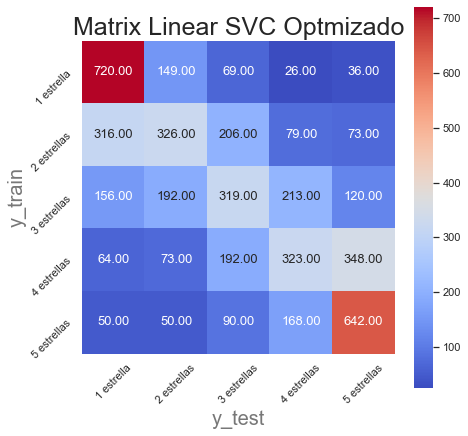

In [84]:
names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm = confusion_matrix(y_test2,y_test_pred_op2)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm',ax=ax)

plt.xlabel("y_test", size =20, color ='#777777')
plt.ylabel("y_train", size =20, color ='#777777')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Matrix Linear SVC Optmizado", size = 25)
plt.show()

No pude optmizar demasiado este modelo y el modelo sigue teniendo dificultad para identificar críticas de 2, 3 y 4 estrellas, pero es muy bueno para identificar los extremos.

#### Validación - ¿Qué información está usando el modelo para predecir?
A continuación genero 5 gráficos con los 10 features positivos mas importantes y los 10 features negativos mas importantes para cada estrella

In [85]:
list_review_test = list(data_test['review_lemm'].values) #test
calif_test = data_test['stars'].values

list_review_dev = list(data['review_lemm'].values) #data dev
calif_dev = data['stars'].values 

vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
#self._vectorizer = vectorizer

matriz_review_test= vectorizer.fit_transform(list_review_test).toarray()
matriz_review_dev = vectorizer.transform(list_review_dev)

all_words = vectorizer.get_feature_names()

print('Train', matriz_review_train.shape)
print('Data dev ', matriz_review_dev.shape)

Train (200000, 360)
Data dev  (5000, 360)


In [86]:
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev= calif_dev.astype('int8')

In [87]:
X_train = matriz_review_train
y_train = calif_train

X_dev = matriz_review_dev
y_dev = calif_dev

In [105]:
svc_test = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', 
                     loss='squared_hinge', C=5, random_state=42)
svc_test.fit(X_train, y_train)
y_train_pred = svc_test.predict(X_train)
y_test_pred = svc_test.predict(X_dev)

print("Accuracy train: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test: ", accuracy_score(y_dev, y_test_pred))

Accuracy train:  0.463525
Accuracy test:  0.4496


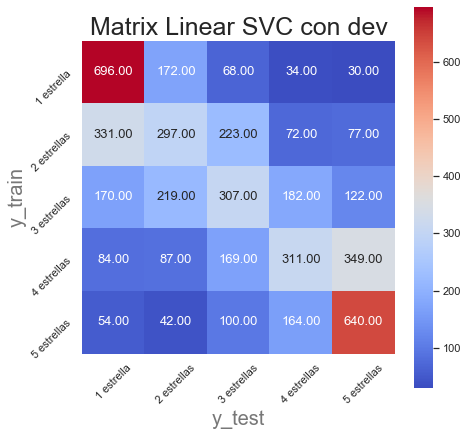

In [89]:
names=["1 estrella","2 estrellas", "3 estrellas", "4 estrellas", "5 estrellas"]
cm = confusion_matrix(y_dev,y_test_pred)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm',ax=ax)

plt.xlabel("y_test", size =20, color ='#777777')
plt.ylabel("y_train", size =20, color ='#777777')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Matrix Linear SVC con dev", size = 25)
plt.show()

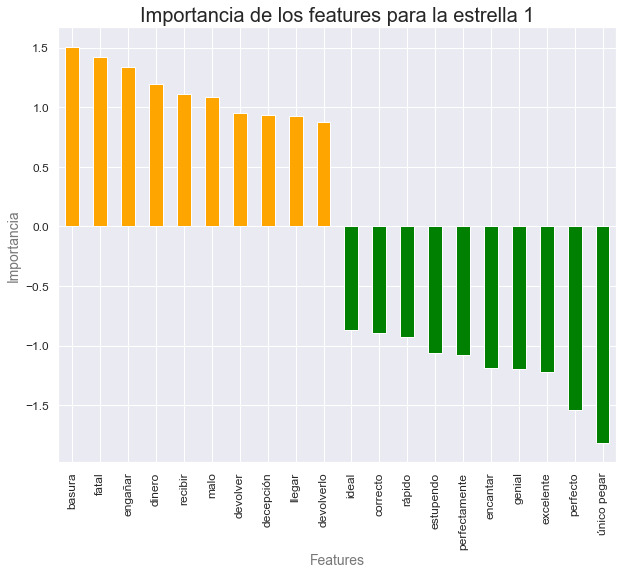

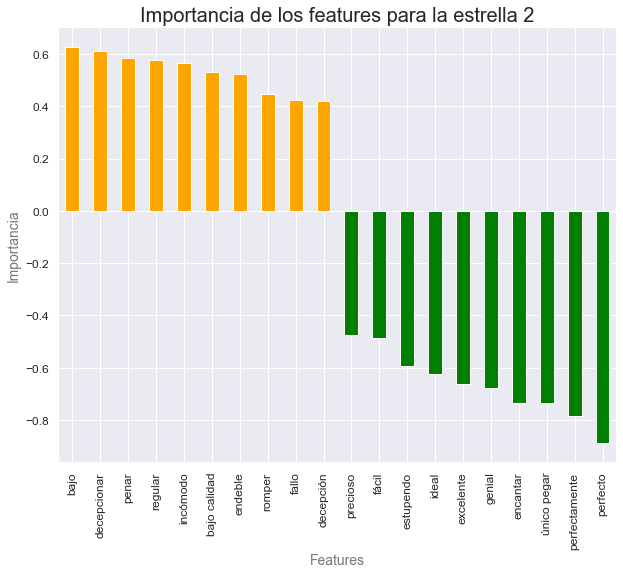

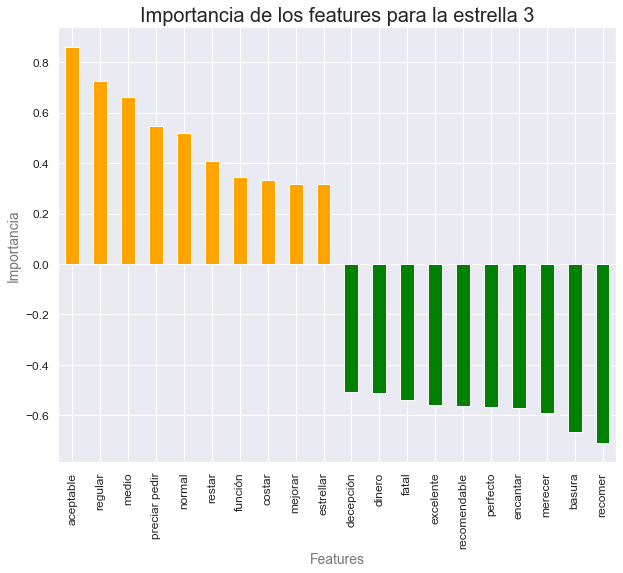

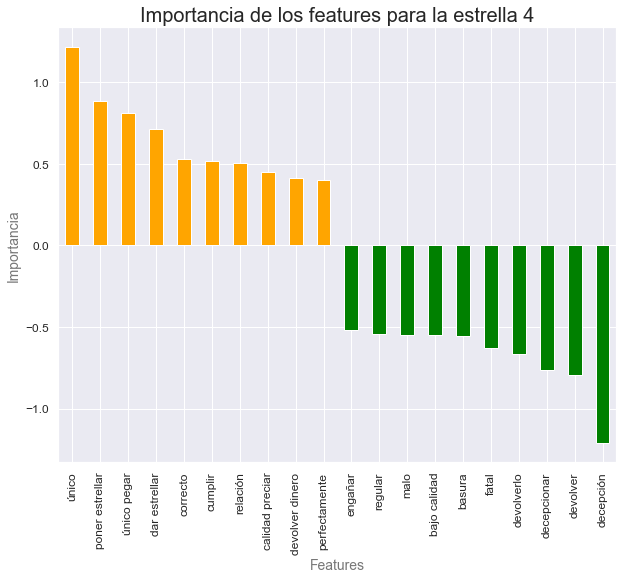

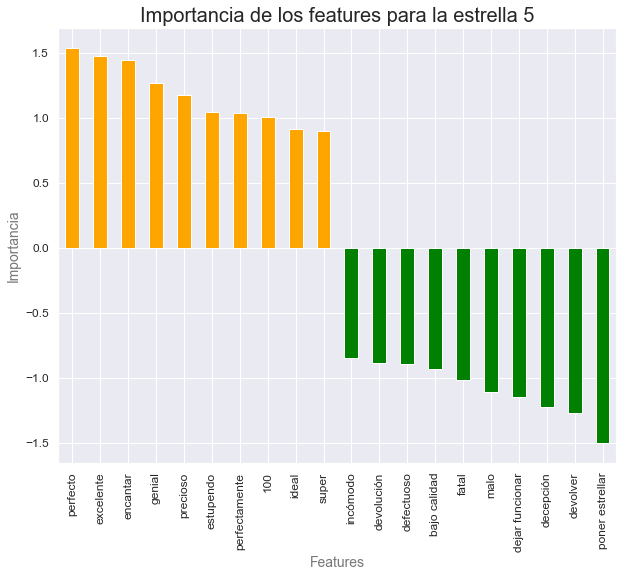

In [90]:
for index_star in range (0,5):
    coeff = list(svc.coef_[index_star])
    labels = list(all_words)
    features = pd.DataFrame()
    features['Features'] = labels
    features['Importance'] = coeff
    features = features.reset_index(drop=True)
    features_sort = features.sort_values(by=['Importance'], ascending=False)
    features_sort = features_sort.reset_index(drop=True)
    data_plot = pd.concat([features_sort.head(10), features_sort.tail(10)])
    data_plot.sort_values(by=['Importance'], ascending=False, inplace = True)
    data_plot['positive'] = data_plot['Importance'] > 0
    data_plot.set_index('Features', inplace = True)
    data_plot.Importance.plot(kind='bar', figsize = (10,8),
                              color = data_plot.positive.map({True: 'orange', False: 'green'}),
                              fontsize=12)
    plt.xlabel ('Features', fontsize=14, color ='#777777')
    plt.ylabel ('Importancia', rotation = 90, fontsize=14, color ='#777777')
    plt.title ('Importancia de los features para la estrella ' + str(index_star+1), fontsize=20)
    plt.show()

Super utiles estos gráficos y resultados para entender cómo esta funcionando nuestro modelo ya que puedo notar que ha identificado bien la intención en las criticas.

### C - Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?


Creo que al poner, en este caso, 5 opciones(estrellas) para calificar un servicio y producto "hace pensar" al usuario, la idea es que mientras más simple más y mejor responde el usuario. Si optamos por etiquetas Positiva y Negativa (Me gusta/No me gusta) + comentario al respecto podemos contar con más información en datos y poder tomar iniciativa de poder calificar mejor en prediciones ML. 
Vi que Netflix ha cambiado sus calificaciones por esto y creo que es mejor, o por lo menos ahora noto que a mí misma me dan ganas de calificar una pelicula una vez de verla.

Podriamos probar cambiando a binario tomando un fragmento del dataset

**0 como Negativo / 1 como Positivo**

Y luego de pensarlo y googlear al respecto puedo calificar:
* 1,2,3 = Negativo - 0
* 4,5 = Positivo - 1

In [91]:
x = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1} #diccionario

data_train['binomial'] = data_train['stars'].map(x)
data_train

,stars,product_category,review_full,review_lemm,binomial
0,1,electronics,television Nevir Nada bueno se me fue ka panta...,television nevir ka pantalla 8 mesar y recibir...,0
1,1,electronics,Dinero tirado a la basura con esta compra Horr...,dinero tirar a basura comprar horrible tener c...,0
2,1,drugstore,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar a comprar obligar a comp...,0
3,1,wireless,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto recibir entrar descalificar vendedor ...,0
4,1,shoes,Devuelto Llega tarde y co la talla equivocada,devolver llegar y co tallar equivocar,0
...,...,...,...,...,...
199995,5,electronics,Tal y como se describe Mando funciona perfecta...,y describir mandar funcionar perfectamente y c...,1
199996,5,electronics,Funciona perfectamente Compré la batería con c...,funcionar perfectamente comprar batería retice...,1
199997,5,apparel,Buena calidad. Buena calidad. Satisfecha con l...,calidad calidad satisfacer comprar,1
199998,5,toy,Recomendado Perfecto para el cumple de mi hijo,recomendar perfecto cumplir hijo,1


In [92]:
x = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1} #diccionario

data_test['binomial'] = data_test['stars'].map(x)
data_test

,stars,product_category,review_full,review_lemm,binomial
0,1,wireless,no me llego no me llego el articulo me lo mand...,llegar llegar articular mandar correo normal s...,0
1,1,home,amazon sigue sin cumplir en las entregas la me...,amazon cumplir entregar mensajería horrible co...,0
2,1,toy,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,estafar enviar decepcionar vendedor pedir a y ...,0
3,1,home,Estafa de Amazon Mi valoración no es sobre el ...,estafar amazon valoración producto amazon ofre...,0
4,1,digital_ebook_purchase,No conseguí pasar de la portada en Kindle Pues...,conseguir pasar portar kindle interés librar y...,0
...,...,...,...,...,...
4995,5,wireless,Perfectos para lo que sirven Para lo que cuest...,perfecto servir costar perfecto cumplir funció...,1
4996,5,wireless,"Buen vendedor, rápido y fiable. Material muy f...",vendedor rápido y fiable material flexible y c...,1
4997,5,home,medallas con bonito grabado Se ve bien el grabado,medalla bonito grabar ver grabar,1
4998,5,sports,timbre lo compré para mi bici pero finalmente ...,timbrar comprar bici finalmente quedar xiaomi ...,1


In [94]:
list_review_train = list(data_train['review_lemm'].values)
calif_train = data_train['binomial'].values

list_review_test = list(data_test['review_lemm'].values)
calif_test = data_test['binomial'].values


vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_test = vectorizer.transform(list_review_test)

print(matriz_review_train.shape)
print(matriz_review_test.shape)

(200000, 1000)
(5000, 1000)


In [95]:
matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')

matriz_review_test = matriz_review_test.astype('float32')
calif_test = calif_test.astype('int8')

In [96]:
Xtrain = matriz_review_train.toarray()
ytrain = calif_train

Xtest = matriz_review_test.toarray()
ytest = calif_test

In [97]:
svc_b = LinearSVC(dual = False, penalty='l1', tol=0.01, multi_class='ovr', 
                loss='squared_hinge', C=10, random_state=42)
svc_b.fit(Xtrain, ytrain)
y_train_predic = svc_b.predict(Xtrain)
y_test_predic = svc_b.predict(Xtest)

print("Accuracy train: ", accuracy_score(ytrain, y_train_predic))
print("Accuracy test: ", accuracy_score(ytest, y_test_predic))

Accuracy train:  0.818875
Accuracy test:  0.818


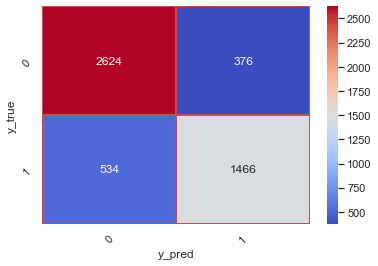

In [114]:
names=['Positivo', 'Negativo']

corr =  confusion_matrix(ytest,y_test_predic)

sns.heatmap(corr,annot=True,linewidth=.5,
            linecolor="r",cmap= 'coolwarm',fmt=".0f")

plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Viendo la nueva matriz, puedo notar que el modelo tiende a equivocarse más cuando predice comentarios malos, pero en realidad son buenos.

Tambien noto que al convertir el problema en un problema binario, los datasets han quedado desbalanciados, 60% de los casos son reviews negativos y 40 % positivos. Este grado de desbalance no es muy alto, por lo que el Accuracy sigue siendo una buena metrica para medir el desempeño del modelo ya en un 80% comparado con lo trabajado anteriormente.

Valido con dev:

In [99]:
x = {1 : 0, 2 : 0, 3 : 0, 4 : 1, 5 : 1}
data['binomial'] = data['stars'].map(x)
data.head()

,stars,product_category,review_full,review_lemm,binomial
0,1,wireless,"Mala compra Malisimo, muy grande demasiado apa...",malo comprar malisimo grande aparatoso y prote...,0
1,1,apparel,No lo he recibido No he recibido el pedido no ...,recibir recibir pedir devolución,0
2,1,sports,Que no aprieta bien en el manillar Tengo que b...,apretar manillar buscar sistema funcionar abra...,0
3,1,home_improvement,Brocas de mantequilla Utilicé las brocas de me...,broca mantequilla utilizar broca menor diámetr...,0
4,1,beauty,No me gusta No me gusta su olor a viejo y aspe...,gustar gustar olor a viejo y aspecto malo,0


In [100]:
list_review_train = list(data_train['review_lemm'].values)
calif_train = data_train['binomial'].values

list_review_dev = list(data['review_lemm'].values)
calif_dev = data['binomial'].values

vectorizer = TfidfVectorizer(max_features=1000, min_df=30, ngram_range=(1, 2))
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_dev = vectorizer.transform(list_review_dev)

print(matriz_review_train.shape)
print(matriz_review_dev.shape)

(200000, 1000)
(5000, 1000)


In [109]:
all_words = vectorizer.get_feature_names()

matriz_review_train = matriz_review_train.astype('float32')
calif_train = calif_train.astype('int8')
matriz_review_dev = matriz_review_dev.astype('float32')
calif_dev = calif_dev.astype('int8')

In [110]:
Xtrain = matriz_review_train.toarray()
ytrain = calif_train
Xdev = matriz_review_dev.toarray()
ydev = calif_dev

In [111]:
svc_dev = LinearSVC(dual = False, penalty='l1', 
                     tol=0.01, multi_class='ovr', loss='squared_hinge', 
                     C=2, random_state=42)
svc_dev.fit(Xtrain, ytrain)
y_train_predicd = svc_dev.predict(Xtrain)
y_dev_predicd = svc_dev.predict(Xdev)

print("Accuracy train: ", accuracy_score(ytrain, y_train_predicd))
print("Accuracy dev: ", accuracy_score(ydev, y_dev_predicd))

Accuracy train:  0.818805
Accuracy dev:  0.8154


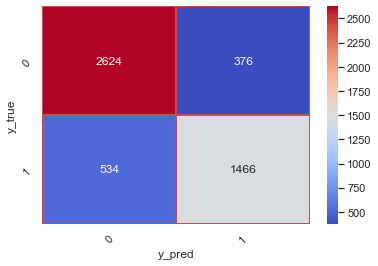

In [112]:
names=['Positivo', 'Negativo']

cor =  confusion_matrix(ydev,y_test_predic)

sns.heatmap(cor,annot=True,linewidth=.5,
            linecolor="r",cmap= 'coolwarm',fmt=".0f")

plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

Veré la importancia de las palabras para las calificaciones binarias en este caso:

In [115]:
top_features=10
coef = svc_b.coef_.ravel()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

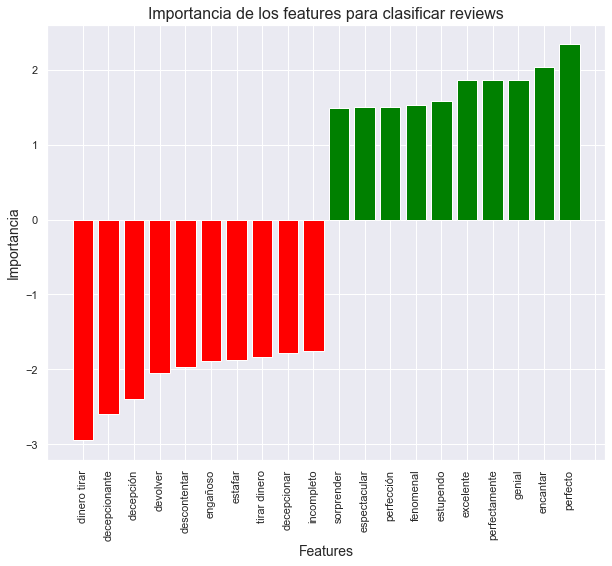

In [116]:
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]

plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
feature_names = np.array(all_words)

plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90)

plt.xlabel ('Features', fontsize=14)
plt.ylabel ('Importancia', rotation = 90, fontsize=14)
plt.title ('Importancia de los features para clasificar reviews', fontsize=16)
plt.show()

In [117]:
top_features=10
coef2 = svc_dev.coef_.ravel()
top_positive_coefficients = np.argsort(coef2)[-top_features:]
top_negative_coefficients = np.argsort(coef2)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

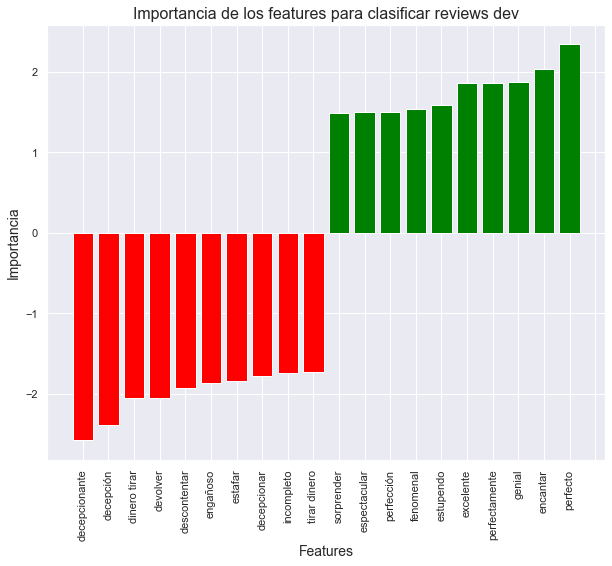

In [118]:
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in coef2[top_coefficients]]

plt.bar(np.arange(2 * top_features), coef2[top_coefficients], color=colors)
feature_names = np.array(all_words)

plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90)

plt.xlabel ('Features', fontsize=14)
plt.ylabel ('Importancia', rotation = 90, fontsize=14)
plt.title ('Importancia de los features para clasificar reviews dev', fontsize=16)
plt.show()

En el gráfico se pueden ver las 10 variables con mayor importancia para clasificar tanto las críticas negativas como las positivas.

Siendo "decepcionante", "dinero tirar", "devolver" la palabra con mayor peso en opiniones malas y "perfecto", "encantar", "genial" en el caso de buenas opioniones, este resultado es muy coherente.

Luego del analisis y como critica personal me quedo pendiente en las optmizaciones de modelos avanzados con muchas fallas y problemas de resolución por recursos de máquina y falta de conocimiento en poder resolver con grandes volumenes de datos en este dataset.